<a href="https://colab.research.google.com/github/audreyyin9877/ITP449/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
[The Ramen Rater](https://www.theramenrater.com/) is a product review website for the hardcore ramen enthusiast (or "ramenphile"). The website, which has been operating since 2002, not only has an extensive list of ramen reviews, but also contains interviews from large ramen companies. The website hosts a link called "[The Big List](https://www.theramenrater.com/resources-2/the-list/)" which contains 2580 unique ramen reviews. Each review contains information on the brand name, variety, style (pack or cup), the country producing the ramen, and a rating out of five stars. 

For this project, I wanted to explore the relationships between ramen ratings, their flavor profiles, and their country of origin. 

This project was completed for USC's ITP 449 Applications of Machine Learning class. 

# Import Libraries



In [26]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import re as re

Read the csv file using Pandas. Store the output into a dataframe named frame.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_handle = drive.CreateFile({'id': '1yGCWpFDfIwq0yoBYnCveu__CKiWcUeYX'}) # to get the ID, go to your google drive, right click on the file and click on get link. Copy the id in the URL
file_handle.GetContentFile('ramen-ratings.csv')

In [29]:
frame = pd.read_csv('ramen-ratings.csv')
print(frame)

      Review #           Brand  \
0         2580       New Touch   
1         2579        Just Way   
2         2578          Nissin   
3         2577         Wei Lih   
4         2576  Ching's Secret   
...        ...             ...   
2575         5           Vifon   
2576         4         Wai Wai   
2577         3         Wai Wai   
2578         2         Wai Wai   
2579         1        Westbrae   

                                                Variety Style   Country Stars  \
0                             T's Restaurant Tantanmen    Cup     Japan  3.75   
1     Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack    Taiwan     1   
2                         Cup Noodles Chicken Vegetable   Cup       USA  2.25   
3                         GGE Ramen Snack Tomato Flavor  Pack    Taiwan  2.75   
4                                       Singapore Curry  Pack     India  3.75   
...                                                 ...   ...       ...   ...   
2575  Hu Tiu Nam Vang ["

# Data Wrangling
Some of the ratings were incomplete in this database. I dropped any instances where a ramen was unrated. I also removed the Top Ten column, as this data was not going to be used.

In [30]:
pd.set_option('display.max_columns', None)
frame.drop(frame[frame["Stars"] == "Unrated"].index, inplace=True)
del frame['Top Ten']
print(frame)
# 3 ramen varieties were dropped.

      Review #           Brand  \
0         2580       New Touch   
1         2579        Just Way   
2         2578          Nissin   
3         2577         Wei Lih   
4         2576  Ching's Secret   
...        ...             ...   
2575         5           Vifon   
2576         4         Wai Wai   
2577         3         Wai Wai   
2578         2         Wai Wai   
2579         1        Westbrae   

                                                Variety Style   Country Stars  
0                             T's Restaurant Tantanmen    Cup     Japan  3.75  
1     Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack    Taiwan     1  
2                         Cup Noodles Chicken Vegetable   Cup       USA  2.25  
3                         GGE Ramen Snack Tomato Flavor  Pack    Taiwan  2.75  
4                                       Singapore Curry  Pack     India  3.75  
...                                                 ...   ...       ...   ...  
2575  Hu Tiu Nam Vang ["Phnom P

# Data Augmentation
There were a few datapoints that I thought would be interesting to explore that were not included in this dataset. For example, I thought that exploring flavor profiles of each ramen would be interesting to look at based upon country and rating. 

## Creating Flavor Profiles
I added a new column that quickly describes flavor profiles using the NLTK library. Key words are extracted from the variety names by removing common words that are not useful in identifying flavors (ex: restaurant, noodles, ramen, flavor etc). 

In [31]:
import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.corpus import wordnet as wordnet
from collections import OrderedDict

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
# Rename the Review # column into ID
df = frame.rename(columns={'Review #': 'ID'})

# Created a new Holder column that is a copy of the Variety column, with the exception that the phrase was split by spaces
df['Holder'] = (df['Variety'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

# Imported common stopwords from the NLTK library. Added non-descriptor ramen words to the stopwords list
stopwords = stopwords.words('english')
newStopWords = ['noodles','restaurant','flavor','flavour','ramen','cup','original','premium','instant','bowl','instant','soup','&','top','base','new','recipe','assorted','taste','sauce','mix',
                'sun','dried','mian','sensation','instan','house','king','delight','singapore','south korea','japan','feast','minute','imitation','cuisine','big','song','stir','gge','artificial',
                'noodle','oriental','style','mein','super', 'snack', 'demae', 'chow']
stopwords.extend(newStopWords)

# get_keywords is a function that removes punctuation, letters, and lowercases every word in "Holder". It then tokenizes each word and removes the word if it is found in stopwords list
def get_keywords(row): 
    text = row['Holder']
    text = text.lower()
    text = re.sub("&lt;/?.*&gt;", '&lt;&gt;', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub("(\\d|\\W)+"," ",text)
    tokens = nltk.tokenize.word_tokenize(text)
    keywords = [keyword for keyword in tokens if keyword.isalpha() and not keyword in stopwords]
    keywords_string = ' '.join(keywords)
    return keywords_string

# Runs the get_keywords function, renames Holder to Flavor Profile
df['Flavor Profile'] = df.apply(lambda row:get_keywords(row), axis=1)

# Reorganizes the dataframe
df = df[["ID","Brand", "Variety", "Flavor Profile", "Style", "Country", "Stars"]]
result = df.head(10)
print(result)


     ID           Brand                                            Variety  \
0  2580       New Touch                          T's Restaurant Tantanmen    
1  2579        Just Way  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...   
2  2578          Nissin                      Cup Noodles Chicken Vegetable   
3  2577         Wei Lih                      GGE Ramen Snack Tomato Flavor   
4  2576  Ching's Secret                                    Singapore Curry   
5  2575   Samyang Foods                             Kimchi song Song Ramen   
6  2574         Acecook                Spice Deli Tantan Men With Cilantro   
7  2573     Ikeda Shoku                              Nabeyaki Kitsune Udon   
8  2572      Ripe'n'Dry                           Hokkaido Soy Sauce Ramen   
9  2571            KOKA              The Original Spicy Stir-Fried Noodles   

                   Flavor Profile Style      Country Stars  
0                       tantanmen   Cup        Japan  3.75  
1      spicy hot se

## Reorganizing Country Data
I wanted to find the number of brands, varities, and the average rating of ramens across countries. 

Find the total number of varities of ramen for each country

In [8]:
country_num = df.ID.groupby([df.Country.str.strip("")]).nunique()
print(country_num)

Country
Australia         22
Bangladesh         7
Brazil             5
Cambodia           5
Canada            41
China            169
Colombia           6
Dubai              3
Estonia            2
Fiji               4
Finland            3
Germany           27
Ghana              2
Holland            4
Hong Kong        137
Hungary            9
India             31
Indonesia        126
Japan            352
Malaysia         155
Mexico            25
Myanmar           14
Nepal             14
Netherlands       15
Nigeria            1
Pakistan           9
Philippines       47
Poland             4
Sarawak            3
Singapore        109
South Korea      307
Sweden             3
Taiwan           224
Thailand         191
UK                69
USA              323
United States      1
Vietnam          108
Name: ID, dtype: int64


Find total number of brands of ramen for each country

In [9]:
country_brand = df.Brand.groupby([df.Country.str.strip("")]).nunique()
print(country_brand)

Country
Australia         5
Bangladesh        3
Brazil            1
Cambodia          2
Canada            9
China            33
Colombia          1
Dubai             1
Estonia           1
Fiji              2
Finland           1
Germany           4
Ghana             2
Holland           1
Hong Kong        12
Hungary           4
India             8
Indonesia        19
Japan            58
Malaysia         32
Mexico            4
Myanmar           2
Nepal             1
Netherlands       4
Nigeria           1
Pakistan          3
Philippines       5
Poland            2
Sarawak           2
Singapore        10
South Korea      35
Sweden            2
Taiwan           47
Thailand         25
UK               12
USA              49
United States     1
Vietnam          19
Name: Brand, dtype: int64


Find the average rating of ramen for each country.

In [10]:
df.dtypes
df["Stars"] = df["Stars"].astype(str).astype(float)

country_avg = df.Stars.groupby([df.Country]).mean()
print(country_avg)

Country
Australia        3.138636
Bangladesh       3.714286
Brazil           4.350000
Cambodia         4.200000
Canada           2.243902
China            3.421893
Colombia         3.291667
Dubai            3.583333
Estonia          3.500000
Fiji             3.875000
Finland          3.583333
Germany          3.638889
Ghana            3.500000
Holland          3.562500
Hong Kong        3.801825
Hungary          3.611111
India            3.395161
Indonesia        4.067460
Japan            3.981605
Malaysia         4.154194
Mexico           3.730000
Myanmar          3.946429
Nepal            3.553571
Netherlands      2.483333
Nigeria          1.500000
Pakistan         3.000000
Philippines      3.329787
Poland           3.625000
Sarawak          4.333333
Singapore        4.126147
South Korea      3.790554
Sweden           3.250000
Taiwan           3.665402
Thailand         3.384817
UK               2.997101
USA              3.457043
United States    3.750000
Vietnam          3.187963
Name

## Reorganizing Brand Data
I wanted to find the number of varities and the average rating of ramens across brands.

Find the average rating of ramen for each brand

In [11]:
brand_avg = df.Stars.groupby([df.Brand]).mean()
print(brand_avg)

Brand
1 To 3 Noodles      4.000000
7 Select            3.750000
7 Select/Nissin     3.500000
A-One               2.750000
A-Sha Dry Noodle    4.067308
                      ...   
Yum Yum             3.750000
Yum-Mie             3.500000
Zow Zow             3.750000
iMee                3.500000
iNoodle             3.000000
Name: Stars, Length: 355, dtype: float64


Find the number of varieities of ramen for each brand 

In [12]:
brand_num = df.Variety.groupby([df.Brand.str.strip("")]).nunique()
print(brand_num)

Brand
1 To 3 Noodles       1
7 Select             2
7 Select/Nissin      1
A-One                4
A-Sha Dry Noodle    26
                    ..
Yum Yum             12
Yum-Mie              1
Zow Zow              1
iMee                 4
iNoodle              2
Name: Variety, Length: 355, dtype: int64


# Data Exploration and Visualization

## Visualization of ramen ratings
I wanted to see what the distribution of ramen ratings looked like.



In [13]:
df['Stars'].describe()

count    2577.000000
mean        3.654676
std         1.015331
min         0.000000
25%         3.250000
50%         3.750000
75%         4.250000
max         5.000000
Name: Stars, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


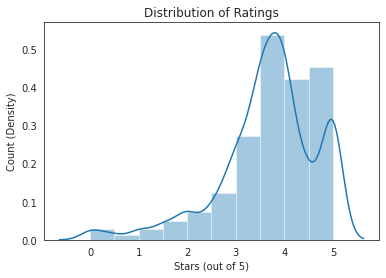

In [14]:
sns.distplot(x=df['Stars'], bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Stars (out of 5)')
plt.ylabel('Count (Density)')
plt.show()

It appears that most of the ramens have a rating between 3.5 to 4. Most ramens are also rated on the higher side, with a score above 3. It also appears that ratings are somewhat bimodal. 

## Visualization of flavor profiles
I wanted to see what the most common flavors were. This was done by counting the frequency that a certain word or phrase appeared. 

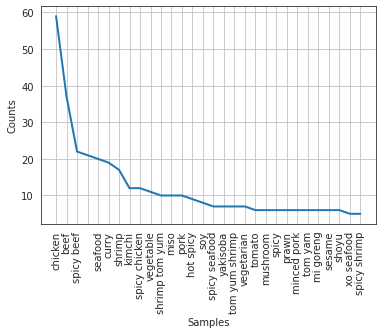

In [15]:
flavors = df['Flavor Profile']
lemmatized_tokens = []
for word in flavors: 
  lemma=nltk.wordnet.WordNetLemmatizer()
  lemmatized_tokens.append(lemma.lemmatize(word))

word_fd = nltk.FreqDist(lemmatized_tokens)
word_fd.plot(30,cumulative=False)

It appears that the most common flavor appears to be chicken, followed by beef and curry. This visualization, however, makes differentiation between beef and spicy beef. If we wanted to count each instance the word "beef" appears as a flavor profile descriptor, the histogram would change to something below: 

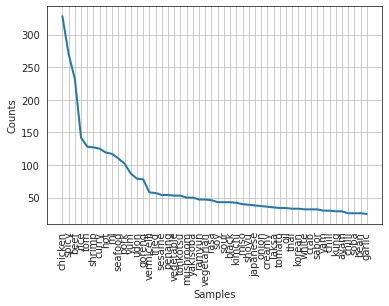

In [16]:
flavors_list = df['Flavor Profile'].tolist()
new_flavors_list = [element for item in flavors_list for element in item.split(' ')]

fdflavor = nltk.FreqDist(new_flavors_list)
fdflavor.plot(50,cumulative=False)

Chicken still remains one of the most popular flavor profiles. Spicy ramen is now the second most popular, followed by beef and rice noodles. 

## Visualization of styles of instant ramen
I wasn't sure if the style of instant ramen had any interesting pattern. As a quick check, I compared the distribution of pack vs cup ramen in this database.

Style
Bar        1
Bowl     481
Box        6
Can        1
Cup      450
Pack    1528
Tray     108
Name: ID, dtype: int64


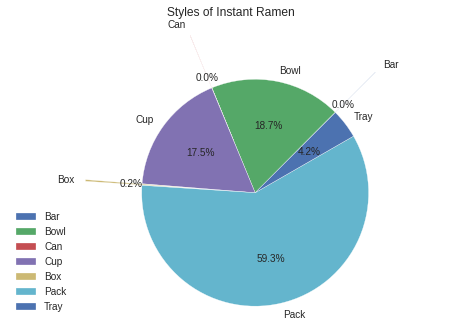

In [17]:
style = df.ID.groupby([df.Style.str.strip("")]).nunique()
print(style)

plt.style.use('seaborn')
styles = ['Bar','Bowl','Can','Cup','Box','Pack','Tray']
freq = [1,481,1,450,6,1528,108]
plt.pie(freq, labels=styles, autopct='%.1f%%', startangle=45,
        explode=[0.5, 0, 0.5, 0, 0.5, 0, 0]) # split and display portion of pie chart
plt.title('Styles of Instant Ramen')
plt.axis('equal')
plt.legend(styles, loc='lower left') # legend
plt.show()


As it turns out, there are more varities of ramen than I thought. The most popular form of ramen is sold in packs, followed by bowls and cups. There were also more "rare" styles of ramen, such as canned ramen, bar ramen, and box ramen. 

# Hypothesis Testing

## Hypothesis 1: Because ramen was invented in Japan, I hypothesize that Japan will produce the most brands of ramen, and have the highest ratings of ramen. 
In order to visualize this, I decided to create a scatter plot that displays each country's average ramen rating, and the number of brands each country has. 

      Country     Stars  Brand
0   Australia  3.138636      5
1  Bangladesh  3.714286      3
2      Brazil  4.350000      1
3    Cambodia  4.200000      2
4      Canada  2.243902      9


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Average Star Rating (out of 5)')

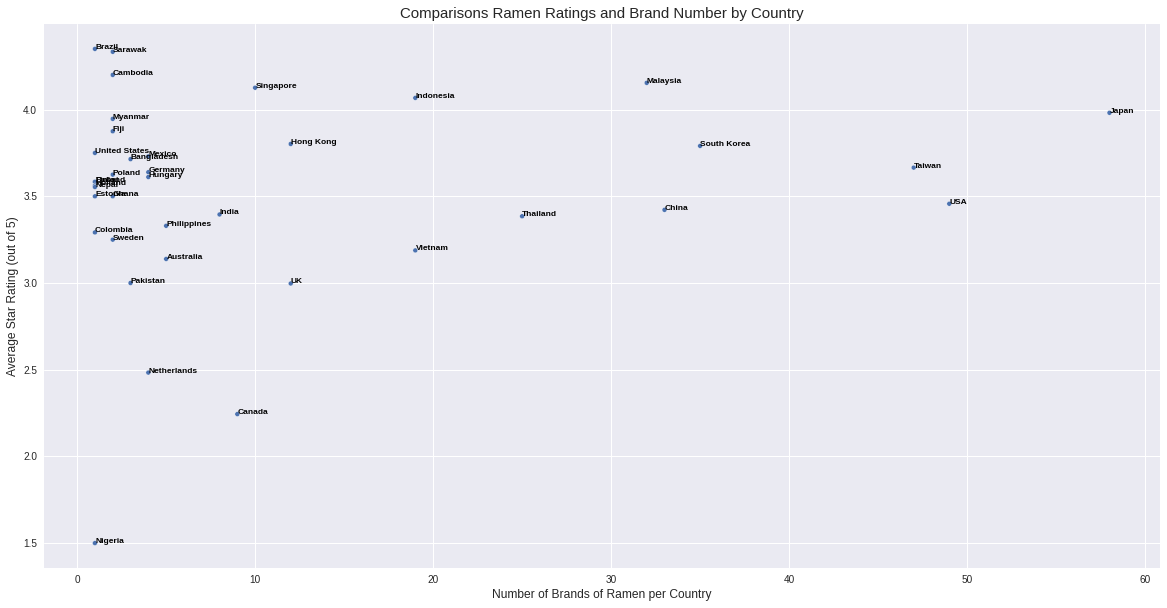

In [18]:
# Concatenated earlier panda series created in Data Augmentation
country_df = pd.concat([country_avg, country_brand], axis=1)
country_df.reset_index(inplace = True)
print(country_df.head())

# scatter_text function displays each country's name next to their datapoint. 
def scatter_text(x, y, text, data):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 10, legend=False)

    # Add text labels
    for entry in range(0,data.shape[0]):
         p1.text(data[x][entry]+0.01, data[y][entry], 
                 data[text][entry], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')
    return p1

# create scatterplot 
plt.figure(figsize=(20,10))
scatter_text('Brand', 'Stars', 'Country', data = country_df)
plt.title('Comparisons Ramen Ratings and Brand Number by Country', size = 15)
plt.xlabel('Number of Brands of Ramen per Country', size = 12)
plt.ylabel('Average Star Rating (out of 5)', size = 12)

My hypothesis was correct. Japan not only had the most brands of ramen, but also had a relatively high average star rating. Following Japan in terms of brand variety is the USA and Taiwan. Even though Brazil did not have many brands of ramen, it did have the highest average star rating. 

## Hypothesis 2: I hypothesize that because chicken is the most common flavor of ramen, that chicken ramens will also have the highest ratings.

In [19]:
# from the visualization of popular flavors, I chose the top 50 popular flavors to test and tag 
taggers = ['chicken', 'spicy', 'beef', 'rice', 'tom yum', 'shrimp', 'curry', 'hot', 'seafood', 
           'pork', 'udon', 'mi goreng', 'vermicelli', 'fried', 'sesame', 'penang', 'garlic',
           'vegetable', 'tonkotsu', 'mushroom', 'yakisoba', 'ramyum', 'vegetarian', 'rasa', 'soy',
           'sour', 'black', 'kimchi', 'miso', 'shoyu', 'japanese', 'onion', 'creamy', 'laksa', 
           'tomato', 'oil', 'thai', 'korean', 'white', 'crab', 'saber', 'yam', 'chili', 'ayam', 'soba', 
           'chilli', 'bean']
taglist = '|'.join(taggers)

# seach_flavor searches each row of Variety, and searches it against the taglist. If the word appears in the taglist, it is added as a tag
# in a new column. If not, NaN is inserted. 
def search_flavor(search_str, search_list): 
  search_obj = re.search(search_list, search_str)
  if search_obj: 
    tag = search_str[search_obj.start(): search_obj.end()]
  else: 
    tag = np.nan
  
  return tag

# Creation of the Flavor Tag column to the original df. Since chili/chilli and spicy/hot are synonymous, they are combined/replaced together. 
df['Flavor Tag'] = df['Flavor Profile'].apply(lambda x: search_flavor(search_str=x, search_list=taglist))
df['Flavor Tag'] = df['Flavor Tag'].replace({'chilli':'chili', 'hot':'spicy'}) 

print(df)

        ID           Brand                                            Variety  \
0     2580       New Touch                          T's Restaurant Tantanmen    
1     2579        Just Way  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...   
2     2578          Nissin                      Cup Noodles Chicken Vegetable   
3     2577         Wei Lih                      GGE Ramen Snack Tomato Flavor   
4     2576  Ching's Secret                                    Singapore Curry   
...    ...             ...                                                ...   
2575     5           Vifon  Hu Tiu Nam Vang ["Phnom Penh" style] Asian Sty...   
2576     4         Wai Wai                     Oriental Style Instant Noodles   
2577     3         Wai Wai                                     Tom Yum Shrimp   
2578     2         Wai Wai                               Tom Yum Chili Flavor   
2579     1        Westbrae                                         Miso Ramen   

                           

In [20]:
# Creation of a new dataframe that counts each time a tag appears, the mean and std of their star ratings
flavor_num = df['Flavor Tag'].value_counts()
flavor_avg = df.Stars.groupby([df['Flavor Tag']]).mean()
flavor_std = df.Stars.groupby([df['Flavor Tag']]).std()

flavor_df = pd.concat([flavor_num, flavor_avg, flavor_std], axis=1)
flavor_df.reset_index(inplace = True)
flavor_df.columns = ['Index', 'Count', 'Average', 'STD']
print(flavor_df)
flavor_df.dtypes

         Index  Count   Average       STD
0        spicy    278  3.648831  1.060524
1      chicken    217  3.335945  0.870477
2         beef    146  3.443322  0.858152
3         rice     91  3.532967  1.036962
4         pork     69  3.390217  1.006041
5       shrimp     68  3.555882  0.738874
6        curry     68  3.952206  0.940643
7         udon     64  3.835938  0.661016
8      seafood     64  3.796875  0.755765
9    mi goreng     51  4.236275  0.868106
10      penang     49  4.744898  0.587389
11    yakisoba     42  4.035714  0.993226
12   vegetable     40  3.131250  1.087498
13        rasa     39  3.775641  0.701959
14  vegetarian     39  2.917949  1.085520
15    tonkotsu     37  4.151351  0.913364
16      sesame     37  3.927027  0.800919
17       chili     37  3.655405  0.965285
18         soy     37  3.527027  1.117698
19     tom yum     36  3.508333  0.895824
20        miso     35  3.722857  1.103160
21       black     34  3.786765  1.255492
22       shoyu     33  4.007576  0

Index       object
Count        int64
Average    float64
STD        float64
dtype: object

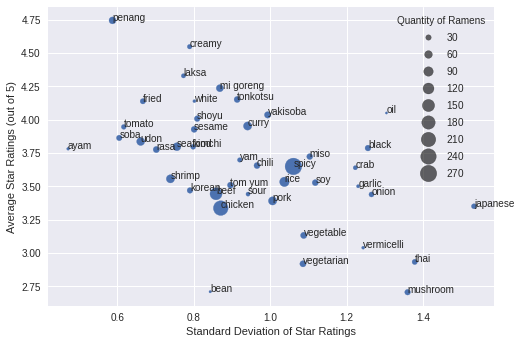

In [21]:
# Creation of a scatteer plot 
fig, ax = plt.subplots()
scatter = ax.scatter(flavor_df['STD'], flavor_df['Average'], s=flavor_df['Count'])

# Adds a legend indicating the quantity of ramens correlated to dot size 
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend1 = ax.legend(handles, labels, loc="upper right", title="Quantity of Ramens")

plt.xlabel("Standard Deviation of Star Ratings")
plt.ylabel("Average Star Ratings (out of 5)")

# labels each dot with the flavor tag
annotations = flavor_df['Index']
for i, label in enumerate(annotations):
    plt.annotate(label, (flavor_df['STD'][i], flavor_df['Average'][i]))

plt.show()

From this, we see that the most popular flavors (chicken, beef, spicy) are, on average, not the highest scored ramens. However, these flavor categories do have considerable spread. Penang, a city in Malaysia (and therfore Malaysian ramen) appears to have the highest average ratings and the a relatively low standard deviation. This also correlates with the previous graph that also showed Malaysia having not only a high average rating across their ramens, but also a high number of brands of ramen as well. 

## Hypothesis 3: I believe that the Nissin company, being one of the biggest ramen producers internationally, will have the highest ratings of ramen.
For every brand of ramen, I found the average star rating of each brand, as well as the number of varieties there were for each brand. This was done because some brands only had one variety, and the goal is to find the highest rated brand of ramen that also provided consistency in rating. 

              Brand     Stars  Variety
0    1 To 3 Noodles  4.000000        1
1          7 Select  3.750000        2
2   7 Select/Nissin  3.500000        1
3             A-One  2.750000        4
4  A-Sha Dry Noodle  4.067308       26


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Average Star Rating (out of 5)')

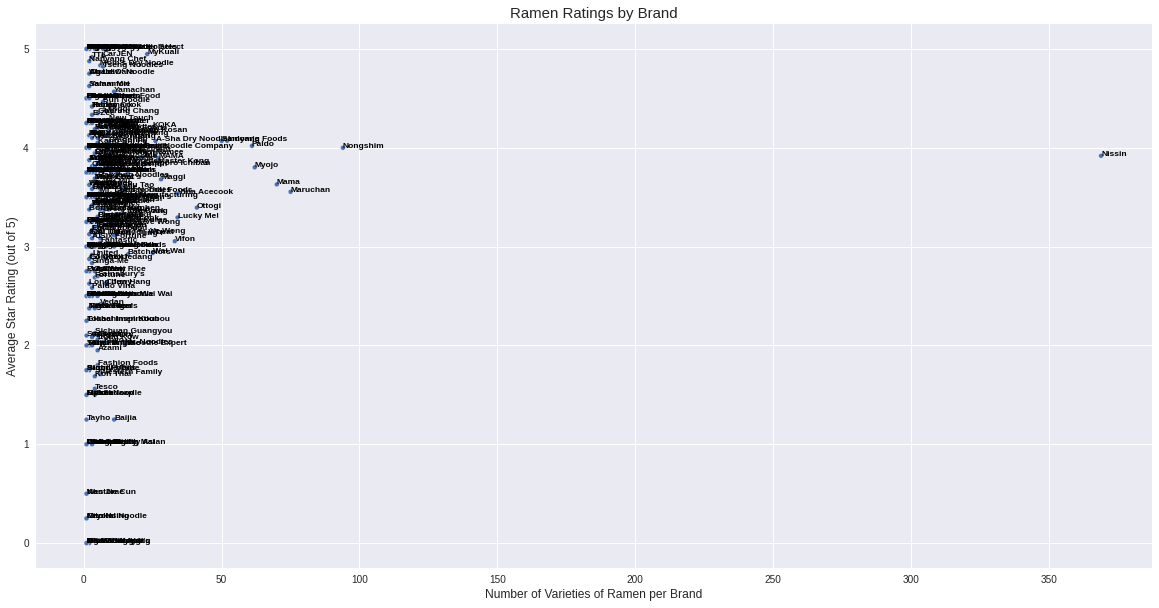

In [22]:
brand_df = pd.concat([brand_avg, brand_num], axis=1)
brand_df.reset_index(inplace = True)
print(brand_df.head())

plt.figure(figsize=(20,10))
scatter_text('Variety', 'Stars', 'Brand', data = brand_df)
plt.title('Ramen Ratings by Brand', size = 15)
plt.xlabel('Number of Varieties of Ramen per Brand', size = 12)
plt.ylabel('Average Star Rating (out of 5)', size = 12)


It appears that one particular brand, Nissin, has a large number of varieties compartively. Nissin appears to have a rating just below 4. If we were to graph the log(variety) we would be able to see a clearer picture: 

              Brand     Stars  Variety  Log Variety
0    1 To 3 Noodles  4.000000        1     1.000000
1          7 Select  3.750000        2     1.693147
2   7 Select/Nissin  3.500000        1     1.000000
3             A-One  2.750000        4     2.386294
4  A-Sha Dry Noodle  4.067308       26     4.258097


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Average Star Rating (out of 5)')

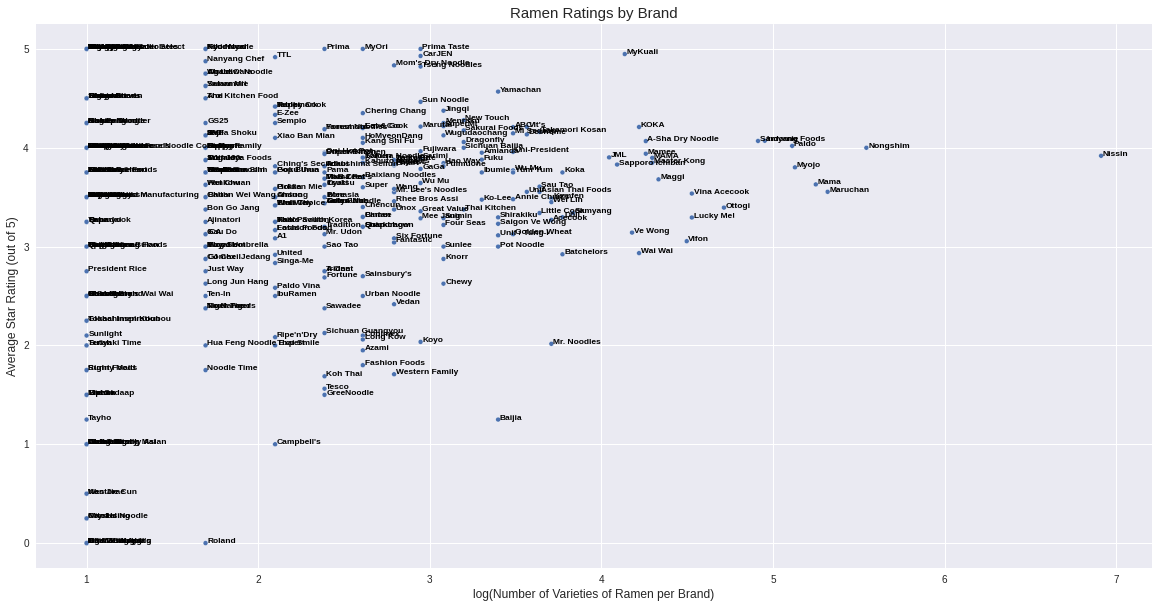

In [23]:
brand_df['Log Variety'] = np.log(brand_df['Variety']) + 1
print(brand_df.head())

plt.figure(figsize=(20,10))
scatter_text('Log Variety', 'Stars', 'Brand', data = brand_df)
plt.title('Ramen Ratings by Brand', size = 15)
plt.xlabel('log(Number of Varieties of Ramen per Brand)', size = 12)
plt.ylabel('Average Star Rating (out of 5)', size = 12)

It appears that Nongshim, Samyang Foods and Paldo are brands of ramen that not only have a wide variety of flavor, but also maintain a star rating of 4 and above. Even though Nissin did not have an above 4 star rating, it was close, and Nissin performed as I had predicted. 

## Hypothesis 4: I hypothesize that box, tray, can, and bar ramens (the least common styles of ramen) will have worse ratings than bowl, cup and pack ramens comparatively
I have never seen canned, bar or tray ramens in my life, and as such, simply just assume that these styles are not as palatable to most consumers. In order to test this, I thought boxplots would best show the median ratings, as well as the distribution of spread for each of the styles. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


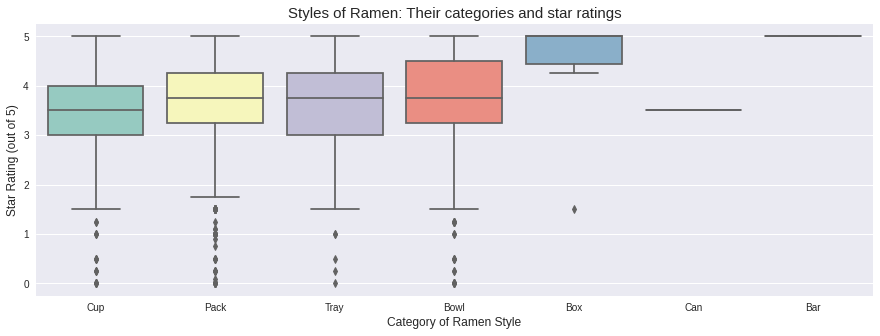

In [24]:
df_new = df[['Style','Stars']]
df_new["Stars"] = df_new["Stars"].astype(str).astype(float)


sns.boxplot(x='Style',y='Stars', data = df_new, palette = 'Set3')
plt.title ('Styles of Ramen: Their categories and star ratings', size = 15)
plt.xlabel('Category of Ramen Style', size = 12)
plt.ylabel('Star Rating (out of 5)', size = 12)
plt.gcf().set_size_inches(15, 5)
plt.show()


My hypothesis was wrong. With the exception of canned and bar ramens (which each only had one entry), the distribution of each of ramen styles ratings that were quite similar. It seems like the style of ramen does not play a large role in the overall taste and rating. 

# Final Conclusions
Most of my ramen hypotheses were proved wrong. It seems that while large ramen companies and ramen countries like Nissin and Japan play a significant role in the ramen industry, they do not appear to produce the highest qualities of ramen. Rather, small to medium companies and country contributors are able to produce, on average, higher star ratings. However, given the quantity of ramens that Nissin and Japan produce, combined with their decent star ratings (approx. 4/5), their ramens seem to be a safe bet when a consumer may not know what to pick. 

Unexpectedly (to me), Malaysia, Malaysian brands (such as MyKuali), and Malaysian flavors (such as penang curry) turned out to produce high ratings with low distribution. The data indicates that everyone should go try that out. 

Also, I found out that Campbell's tried to make a ramen brand. According to the data, it did not turn out well for them. Avoid them at all costs. 

While exploring ramen ratings is not the *most* pressing or hot-button issue of today, I hope people are still able to glean some interesting patterns from the data I have presented. 